# Unit commitment Formulation 

Unit commitment(UC) problem is a fundamental nonlinear non-convex NP-hard optimization problem which makes finding optimal solution difficult. The problem is usually modeled as a mixed-integer programming. The objective of UC problem is to achieve a common target given a set of generating units  subject to  a set of constraints.

The importance of the problem is reflected on the large different approaches suggested to solve the problem which requires requires fast decisions. Quantum computers may provide and advantage in this case.


## Problem Statement

The problem of Unit Commitment deals with what generators should be turned on/off and when depending on the demand so as to minimize costs.

 The setup is as follows. We have a power grid with various power generation units(nodes) that are connected by transmission lines. For simplicity, we assume that we have a set of nodes with one load. The transmission costs is identical(no edges in this case). To simplify the problem even furhter, we only consider one time step. Each node has a set of physical characterisctis: 
 
 A: fixed cost of the unit when it is turned on regardless of the power level.
 
 B: linear cost based on the power level.
 
 C: quandratic cost based on the power level.
 
 Total cost per unit: $C(P) = A + B*P + C* P^2$ where $P$ is the allocatated power to the unit. Classical methods are used to find this paparmeter like economic dispatch.  The total cost is  the sum of the costs of the units that are on.

 
 
 $P_{min}$: minimum generation limit.
 
 $P_{max}$: maximum generation limit.
 
There are many other operational parameters that can be added easily. For simplicity, we consider these. Fig. 1 demonstrates two ways that the load of a 4-unit system could be met while keeping within each unit’s
constraints, and gives the cost of each configuration [[1]](https://arxiv.org/abs/2110.12624).


![alt text](./images/uc.jpg "ref[]")



Thus the  variant we are dealing with can be formulated as the following binary problem:

$$
\begin{aligned}
 min & \sum_{i=1}^{n} y_i C_i(P) = \sum_{i=1}^{n}(y_i(A_i + B_i*P_i + C_i* P_{i}^{2}))\\
  \text{subject to} & \\
&\sum_{i=1}^{n} P_i = L \\
& P_{min,i}  \leq P_i y_i \leq P_{max,i}\\
\end{aligned}
$$

Here, $y_i$ is a binary variable representing the state of the i-th generator ; 1 if on, 0 if
off. $A_i,B_i , C_i$ are constants ,  $P_i  \in \mathbb{R}$. $L$ is the load.

Following [[1]](https://arxiv.org/abs/2110.12624), we convert the constrained equation above into unconstrained one adding some penalty terms:


$$
\begin{aligned}
 min & \sum_{i=1}^{n} y_i C_i(P) = \sum_{i=1}^{n}(y_i(A_i + B_i*P_i + C_i* P_{i}^{2}))\\
  \text{subject to} & \\
&\sum_{i=1}^{n} \lambda_1 * y_i(P_i -L )^{2} \\
&  \lambda_2 * y_i(P_i -  s_{1,i} -  P_{min,i})^{2} \\
&  \lambda_3 * y_i(P_i +  s_{2,i} -  P_{max,i})^{2} \\
\end{aligned}
$$

where $\lambda_1 , \lambda_2 , \lambda_3$ are some empirical constant , $s_{1,i} ,s_{2,i}$ are some penalty terms where $s_{1,i} = P_i -  P_{min,i}$ , $s_{2,i} = P_{max,i} - P_i$.


## Algorithm overview

We use QAOA to handle the problem of whether the unit is one or off and classical optimzer to handle the continuous variables $\gamma_{j}$ , $\beta_{j}$ and $P_{i}$ for $j = 1,2,...,p$ , for $i = 1,2,...,n$ where $n$ is the number of generating units and $p$ is the depth of the circuit. Our main task then would be to construct the cost layer( problem Hamiltonian ). For mixing Hamiltonian,  We will just use the default mixer layer with $R_X$ gates.

Let the input bitstring represent $y$. The i-th qubit  will represent whether the i-th generator is on (|1⟩) or off (|0⟩). The function of a cost layer  is to take this input state and add a phase to it, with the phase angle being the cost of the input state times some $\gamma_{i}$.

We need convert  binary variables $y_i \in \{0, 1\}$ to $z_i \in \{+1, −1\}$  by using the transformation $z_i = 2y_i − 1$ to comply with the standard form for QUBOs solved by QAOA.

[These Cost and Mixing Hamiltonian steps are repeated $P$ times before terminating measurements on each qubit.]

The problem Hamiltonian specific to the above problem is:

$$
\begin{aligned}
H_p & = ??? \\
U(H_p) &= e^{-i\gamma H_p} = ???
\end{aligned}
$$

### The Initial State

We use the default initial state of the QAOA

$$\lvert \psi_0 \rangle = \bigg(\frac{1}{\sqrt{2}}\big(\lvert 0 \rangle + \lvert 1 \rangle\big)\bigg)^{\otimes n}$$


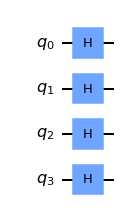

In [54]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw("mpl")

### The Mixing Hamiltonian


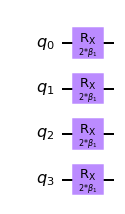

In [64]:
from qiskit import QuantumCircuit , QuantumRegister
from qiskit.tools.visualization import circuit_drawer
from qiskit.circuit import Parameter , ParameterVector
from qiskit.circuit import Gate

nqubits = 4
qr = QuantumRegister(nqubits, 'q')

qc_mix = QuantumCircuit(nqubits)

beta = Parameter("$\\beta_1$")

qc_mix.rx(2 *beta, qr)

qc_mix.draw("mpl")

 ### The Problem Hamiltonian
Since the cost function terms are independent and commutative.

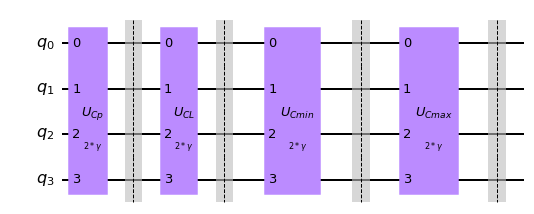

In [56]:
    ## all this represent cost layer
gamma = Parameter("$ 2* \\gamma$")
qc_p = QuantumCircuit(qr)

Cp = Gate(name="$U_{Cp}$", num_qubits=4, params=[gamma])
CL = Gate(name="$U_{CL}$", num_qubits=4, params=[gamma])
Cmin = Gate(name="$U_{Cmin}$", num_qubits=4, params=[gamma])
Cmax = Gate(name="$U_{Cmax}$", num_qubits=4, params=[gamma])

qc_p.append(Cp , qr)
qc_p.barrier()

qc_p.append(CL , qr)
qc_p.barrier()

qc_p.append(Cmin , qr)
qc_p.barrier()

qc_p.append(Cmax , qr)
qc_p.barrier()

qc_p.draw("mpl")

where $Cp$ corresponds to the first term of the cost function above, $CL$ , $Cmin$ and $Cmax$ correspond to the following constraints. 

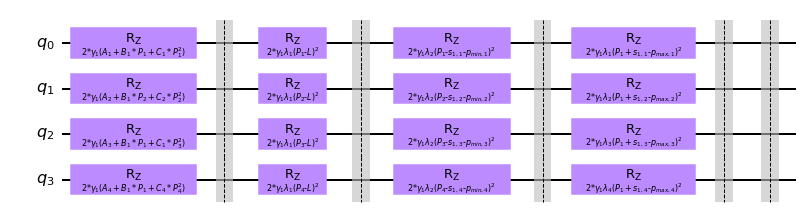

In [57]:
## A brute-Force circuit :)

qr = QuantumRegister(nqubits, 'q')
qc_p = QuantumCircuit(qr)

# Add the first cost circuit
gammacp1 = Parameter("$  \\gamma_1 (A_1 + B_1*P_1 + C_1* P_{1}^{2})$")
qc_p.rz(2 * gammacp1, qr[0])

gammacp2 = Parameter("$  \\gamma_1 (A_2 + B_1*P_2 + C_2* P_{2}^{2})$")
qc_p.rz(2 * gammacp2, qr[1])

gammacp3 = Parameter("$  \\gamma_1 (A_3 + B_1*P_1 + C_1* P_{3}^{2})$")
qc_p.rz(2 * gammacp3, qr[2])

gammacp4 = Parameter("$  \\gamma_1 (A_4 + B_1*P_1 + C_4* P_{4}^{2})$")
qc_p.rz(2 * gammacp4, qr[3])

qc_p.barrier()
# Add the second cost circuit

gammacl1 = Parameter("$  \\gamma_1 \\lambda_1(P_1 - L)^{2}$")
qc_p.rz(2 * gammacl1, qr[0])

gammacl2 = Parameter("$  \\gamma_1 \\lambda_1(P_2 - L)^{2}$")
qc_p.rz(2 * gammacl2, qr[1])

gammacl3 = Parameter("$  \\gamma_1 \\lambda_1(P_3 - L)^{2}$")
qc_p.rz(2 * gammacl3, qr[2])

gammacl4 = Parameter("$  \\gamma_1 \\lambda_1(P_4 - L)^{2}$")
qc_p.rz(2 * gammacl4, qr[3])

qc_p.barrier()
# Add the third cost circuit
gammacmin1 = Parameter("$  \\gamma_1 \\lambda_2(P_1 - s_{1,1} - p_{min,1})^{2} $")
qc_p.rz(2 * gammacmin1, qr[0])

gammacmin2 = Parameter("$   \\gamma_1 \\lambda_2(P_2 - s_{1,2} - p_{min,2})^{2} $")
qc_p.rz(2 * gammacmin2, qr[1])

gammacmin3 = Parameter("$  \\gamma_1 \\lambda_2(P_3 - s_{1,3} - p_{min,3})^{2} $")
qc_p.rz(2 * gammacmin3, qr[2])

gammacmin4 = Parameter("$  \\gamma_1 \\lambda_2(P_4 - s_{1,4} - p_{min,4})^{2} $")
qc_p.rz(2 * gammacmin4, qr[3])

qc_p.barrier()
# Add the fourth cost circuit

gammacmax1 = Parameter("$  \\gamma_1 \\lambda_1(P_1 + s_{1,1} - p_{max,1})^{2} $")
qc_p.rz(2 * gammacmax1, qr[0])

gammacmax2 = Parameter("$  \\gamma_1 \\lambda_2(P_1 + s_{1,2} - p_{max,2})^{2} $")
qc_p.rz(2 * gammacmax2, qr[1])

gammacmax3 = Parameter("$  \\gamma_1 \\lambda_3(P_1 + s_{1,3} - p_{max,3})^{2} $")
qc_p.rz(2 * gammacmax3, qr[2])

gammacmax4 = Parameter("$  \\gamma_1 \\lambda_4(P_1 + s_{1,4} - p_{max,4})^{2} $")
qc_p.rz(2 * gammacmax4, qr[3])
qc_p.barrier()
qc_p.barrier()


qc_p.draw("mpl")

## Putting it all together


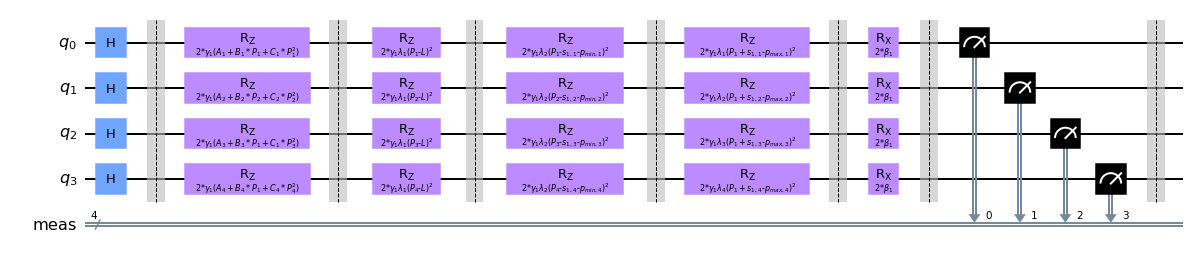

In [73]:
## A brute-Force circuit :)

qr = QuantumRegister(nqubits, 'q')
qc_p = QuantumCircuit(qr)

for i in range(0, nqubits):
    qc_p.h(i)


qc_p.barrier()

# Add the first cost circuit
gammacp1 = Parameter("$  \\gamma_1 (A_1 + B_1*P_1 + C_1* P_{1}^{2})$")
qc_p.rz(2 * gammacp1, qr[0])

gammacp2 = Parameter("$  \\gamma_1 (A_2 + B_2*P_2 + C_2* P_{2}^{2})$")
qc_p.rz(2 * gammacp2, qr[1])

gammacp3 = Parameter("$  \\gamma_1 (A_3 + B_3*P_1 + C_1* P_{3}^{2})$")
qc_p.rz(2 * gammacp3, qr[2])

gammacp4 = Parameter("$  \\gamma_1 (A_4 + B_4*P_1 + C_4* P_{4}^{2})$")
qc_p.rz(2 * gammacp4, qr[3])

qc_p.barrier()
# Add the second cost circuit

gammacl1 = Parameter("$  \\gamma_1 \\lambda_1(P_1 - L)^{2}$")
qc_p.rz(2 * gammacl1, qr[0])

gammacl2 = Parameter("$  \\gamma_1 \\lambda_1(P_2 - L)^{2}$")
qc_p.rz(2 * gammacl2, qr[1])

gammacl3 = Parameter("$  \\gamma_1 \\lambda_1(P_3 - L)^{2}$")
qc_p.rz(2 * gammacl3, qr[2])

gammacl4 = Parameter("$  \\gamma_1 \\lambda_1(P_4 - L)^{2}$")
qc_p.rz(2 * gammacl4, qr[3])

qc_p.barrier()
# Add the third cost circuit
gammacmin1 = Parameter("$  \\gamma_1 \\lambda_2(P_1 - s_{1,1} - p_{min,1})^{2} $")
qc_p.rz(2 * gammacmin1, qr[0])

gammacmin2 = Parameter("$   \\gamma_1 \\lambda_2(P_2 - s_{1,2} - p_{min,2})^{2} $")
qc_p.rz(2 * gammacmin2, qr[1])

gammacmin3 = Parameter("$  \\gamma_1 \\lambda_2(P_3 - s_{1,3} - p_{min,3})^{2} $")
qc_p.rz(2 * gammacmin3, qr[2])

gammacmin4 = Parameter("$  \\gamma_1 \\lambda_2(P_4 - s_{1,4} - p_{min,4})^{2} $")
qc_p.rz(2 * gammacmin4, qr[3])

qc_p.barrier()
# Add the fourth cost circuit

gammacmax1 = Parameter("$  \\gamma_1 \\lambda_1(P_1 + s_{1,1} - p_{max,1})^{2} $")
qc_p.rz(2 * gammacmax1, qr[0])

gammacmax2 = Parameter("$  \\gamma_1 \\lambda_2(P_1 + s_{1,2} - p_{max,2})^{2} $")
qc_p.rz(2 * gammacmax2, qr[1])

gammacmax3 = Parameter("$  \\gamma_1 \\lambda_3(P_1 + s_{1,3} - p_{max,3})^{2} $")
qc_p.rz(2 * gammacmax3, qr[2])

gammacmax4 = Parameter("$  \\gamma_1 \\lambda_4(P_1 + s_{1,4} - p_{max,4})^{2} $")
qc_p.rz(2 * gammacmax4, qr[3])

qc_p.barrier()

# Add the first mixer layer

beta1 = Parameter("$\\beta_1$")


qc_p.rx(2 *beta1, qr)


qc_p.measure_all()

qc_p.barrier()


qc_p.draw("mpl")

### Implementation

TODO

In [66]:


import numpy as np


class Node:

    def __init__(self, A, B, C, minCapacity , maxCapacity):
        self.A = A
        self.B = B
        self.C = C
        self.minCapacity = minCapacity
        self.maxCapacity = maxCapacity
    def cost(p):
        assert p > self.minCapacity , "power should be greater than minimum power"
        assert p < self.maxCapacity, "power should be smaller than maximum power"
        return A + B*p + C * p**2
    


In [67]:
## Edges are not used in this simple example
class Edge:

    def __init__(self, node1, node2, transmission_cost):
        self.node1 = node1
        self.node2 = node2
        self.transmission_cost = transmission_cost


In [68]:
def input_nodes():
    n=int(input("Enter number of nodes: "))
    print("Enter ABC for each node: ")
    nodes = []
    for i in range(0, n):
        a=int(input("Enter a: "))
        b=int(input("Enter b: "))
        c=int(input("Enter c: "))
        minC=int(input("Enter minimum capacity: "))
        maxC=int(input("Enter maximum capacity: "))
        nodes.append(Node(a , b , c , minC , maxC))

    print("nodes added successfuly!")
    return nodes

In [69]:

class UCProblem:

    def __init__(self, load , Nodes):
        self.load = load
        self.Nodes = Nodes
        #self.Edges = Edges
        #self.timestep_count = timestep_count
        #self.grid_timesteps = [Grid(lines, nodes, [True for _ in nodes]) for t in timestep_count]

    def compute_cost(self , pCommit):
        total_Cost = 0.0
        for index in range(len(self.Nodes)):
            total_Cost  =+ nodes[index].cost(pCommit[index])
        return  total_Cost   
    def compute_power_distribution():
        return
        #todo

In [70]:
pCommit = [30,30,30]
load  = 100.0
uc  = UCProblem(load , nodes)
print('total cost=$ %.3f'%(uc.compute_cost(pCommit)))


NameError: name 'nodes' is not defined

## Example with Exact classical solution (TODO)

We will use IBM [CPLEX](https://www.ibm.com/analytics/cplex-optimizer) to approximate a solution of a station having $10$ units with the characterisitcs shown on table (1)




![alt text](./images/table1.jpg "ref[]")





## Conclusion (TODO)

Number of gates required is $O(3N*P)$  where $N$ is the number of nodes and $P$ is the depth of the circuit.

####  References

- [[1] Adapting Quantum Approximation Optimization Algorithm (QAOA) for Unit Commitment
](https://arxiv.org/abs/2110.12624) by Samantha Koretsky et al.